# Perform a LCOH analysis for an offshore wind + Hydrogen PEM system

### Missing Functionality:
1. Offshore wind site locations and cost details (4 sites, $1300/kw capex + BOS cost which will come from Orbit Runs)
2. Cost Scaling Based on Year (Have Weiser et. al report with cost scaling for fixed and floating tech, will implement)
3. Cost Scaling Based on Plant Size (Shields et. Al report)
4. Integration Required:
* Pressure Vessel Model 
* HVDC Model 
* Pipeline Model 

5. Model Development Required:
- Floating Electrolyzer Platform

### Load necessary modules

In [380]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
import os
import sys
sys.path.append('')
from dotenv import load_dotenv
import pandas as pd
import json
from hybrid.sites import SiteInfo
from hybrid.sites import flatirons_site as sample_site
from hybrid.keys import set_developer_nrel_gov_key
# from plot_reopt_results import plot_reopt_results
# from run_reopt import run_reopt
from examples.H2_Analysis.hopp_for_h2 import hopp_for_h2
from examples.H2_Analysis.run_h2a import run_h2a as run_h2a
from examples.H2_Analysis.simple_dispatch import SimpleDispatch
import examples.H2_Analysis.run_h2_PEM as run_h2_PEM
import numpy as np
import numpy_financial as npf
from lcoe.lcoe import lcoe as lcoe_calc
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set API key

In [381]:
load_dotenv()
NREL_API_KEY = os.getenv("NREL_API_KEY")
set_developer_nrel_gov_key(NREL_API_KEY)  # Set this key manually here if you are not setting it using the .env


# Step 1: Establish output structure and special inputs

In [382]:
# save_all_runs = pd.DataFrame()

resource_year = 2013
sample_site['year'] = resource_year
useful_life = 30
critical_load_factor = 1
run_reopt_flag = False
custom_powercurve = True
storage_used = True
battery_can_grid_charge = False
grid_connected_hopp = False
interconnection_size_mw = 100
electrolyzer_size = 100
fixed_or_floating_wind = 'fixed' #floating

# which plots to show
plot_power_production = True
plot_battery = True
plot_grid = True
plot_h2 = True
turbine_name = '2020ATB_18MW'

if turbine_name == '2020ATB_12MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_12MW_214.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_12MW_214.html
    tower_height = 136
    rotor_diameter = 214
    turbine_rating_mw = 12
    wind_cost_kw = 1300
    wind_bos_cost_kw = 500
elif turbine_name == '2020ATB_15MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_15MW_240.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_15MW_240.html
    tower_height = 150
    rotor_diameter = 240
    turbine_rating_mw = 15
    wind_cost_kw =  1300
    wind_bos_cost_kw = 400
elif turbine_name == '2020ATB_18MW':
    custom_powercurve_path = '2020ATB_NREL_Reference_18MW_263.csv' # https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_18MW_263.html
    tower_height = 156
    rotor_diameter = 263
    turbine_rating_mw = 18
    wind_cost_kw = 1300
    wind_bost_cost_kw = 300

# Step 2b: Set Scenario Details Manually

In [384]:
scenario = dict()
kw_continuous = electrolyzer_size * 1000
load = [kw_continuous for x in
        range(0, 8760)]  # * (sin(x) + pi) Set desired/required load profile for plant

# Load Excel file of scenarios
import pandas as pd
path = ('examples/H2_Analysis/OSW_H2_sites_and_costs.xlsx')
xl = pd.ExcelFile(path)
print(xl.sheet_names)
scenario_df = xl.parse('Sheet1')
scenario_df.set_index(["Parameter"], inplace = True)


scenario_choice = 'Offshore Wind-H2 Analysis'
site_name = 'New York Offshore Fixed'
distance_from_shore = 10 #km
sample_site['lat'] = 39.532
sample_site['lon'] = -73.5
lat = sample_site['lat']
lon = sample_site['lon']
atb_year = 2025
ptc_avail = 'yes'
itc_avail = 'no'
discount_rate = 0.07
forced_sizes = True
force_electrolyzer_cost = True
forced_wind_size = 100
forced_solar_size = 1
forced_storage_size_mw = 1
forced_storage_size_mwh = 1
forced_electrolyzer_cost = 400

solar_cost_kw = 9999
storage_cost_kw = 250
storage_cost_kwh = 240
debt_equity_split = 60

# sell_price = 0.01
# buy_price = 0.01

sell_price = False
buy_price = False


site = SiteInfo(sample_site, hub_height=tower_height)

scenario['Useful Life'] = useful_life
scenario['Debt Equity'] = debt_equity_split
scenario['PTC Available'] = ptc_avail
scenario['ITC Available'] = itc_avail
scenario['Discount Rate'] = discount_rate
scenario['Tower Height'] = tower_height
scenario['Powercurve File'] = custom_powercurve_path

print("Powercurve Path: ", custom_powercurve_path)
scenario_df[0:21]

['Sheet1']
Powercurve Path:  2020ATB_NREL_Reference_18MW_263.csv


,Site 1,Site 2,Site 3,Site 4,Notes
Parameter,,,,,
Representative region,Gulf of Mexico (west portion of Call Area),Central Atlantic (Call Area E),New York Bight (Bright Wind Holdings Lease),California (Humboldt Lease Area),NaN
Representative coordinates,"27.18624, -96.9516","37.48358, -73.72925","39.53852, -73.1956","40.95078, -124.63619",Just in case we want to pull wind resource dat...
Substructure technology,Fixed - Monopile,Floating - semisubmersible,Fixed - Monopile,Floating - semisubmersible,Jackets could be the preferred fixed technolog...
Plant capacity,1008 MW,1008 MW,1008 MW,1008 MW,84 turbines
Turbine rating,12 MW,12 MW,12 MW,12 MW,NaN
Turbine layout,7D x 7D square grid,7D x 7D square grid,7D x 7D square grid,7D x 7D square grid,simplistic
Approx. water depth,45 m,2000 m,40 m,850 m,NaN
Approx. distance to port,80 km,110 km,100 km,55 km,NaN
Approx. distance to export cable landfall,85 km,110 km,80 km,45 km,NaN


## Step 2c: Display Future Cost Reduction Estimates



In [385]:
# Floating Wind Cost Reductions
parent_path = os.path.abspath('')
floating_cost_reductions_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/floating_cost_reductions.csv'))

# Fixed Wind Cost Reductions
fixed_cost_reductions_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/fixed_cost_reductions.csv'))

if fixed_or_floating_wind == 'fixed':
    capex_reduction = fixed_cost_reductions_df[str(atb_year)][0]
    opex_reduction = fixed_cost_reductions_df[str(atb_year)][1]
    net_cf_increase = fixed_cost_reductions_df[str(atb_year)][2]
elif fixed_or_floating_wind == 'floating':
    capex_reduction = floating_cost_reductions_df[str(atb_year)][0]
    opex_reduction = floating_cost_reductions_df[str(atb_year)][1]
    net_cf_increase = floating_cost_reductions_df[str(atb_year)][2]

print("For {} wind in {}, capex reduction is estimated to be: {}, opex reduction is: {}, and net capacity factor increase is: {}.".format(fixed_or_floating_wind, str(atb_year), capex_reduction, opex_reduction, net_cf_increase))

For fixed wind in 2025, capex reduction is estimated to be: 11.50%, opex reduction is: 8.25%, and net capacity factor increase is: 2.63%.


# Step 2d: Display Turbine and Plant Cost Scaling Estimates

##### Estimates From: "Impacts of turbine and plant upsizing on the levelized cost of energy for offshore wind" -  Shields et. Al 2021

In [386]:
# Inputs: Turbine Rating and Design, Plant Capacity, Plant Layout.

# Step 3: Set up HOPP run

In [387]:
if forced_sizes:
    solar_size_mw = forced_solar_size
    wind_size_mw = forced_wind_size
    storage_size_mw = forced_storage_size_mw
    storage_size_mwh = forced_storage_size_mwh
    storage_hours = 0


technologies = {'pv':
                    {'system_capacity_kw': solar_size_mw * 1000},
                'wind':
                    {'num_turbines': np.floor(wind_size_mw / turbine_rating_mw),
                        'turbine_rating_kw': turbine_rating_mw*1000,
                        'hub_height': tower_height,
                        'rotor_diameter': rotor_diameter},
                'battery': {
                    'system_capacity_kwh': storage_size_mwh * 1000,
                    'system_capacity_kw': storage_size_mw * 1000
                    }
                }

hybrid_plant, combined_pv_wind_power_production_hopp, combined_pv_wind_curtailment_hopp,\
energy_shortfall_hopp, annual_energies, wind_plus_solar_npv, npvs, lcoe =  \
    hopp_for_h2(site, scenario, technologies,
                wind_size_mw, solar_size_mw, storage_size_mw, storage_size_mwh, storage_hours,
    wind_cost_kw, solar_cost_kw, storage_cost_kw, storage_cost_kwh,
    kw_continuous, load,
    custom_powercurve,
    electrolyzer_size, grid_connected_hopp=True)

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost

['test_BatteryStateful.py', 'tools', 'HOPP.egg-info', '.DS_Store', 'workspace.code-workspace', 'LICENSE', 'requirements.txt', '.pytest_cache', 'dist', 'onshore_h2_analysis.ipynb', 'tests', '__init__.py', '__pycache__', 'docs', '.readthedocs.yml', 'osw_h2_analysis.ipynb', 'README.md', 'RELEASE.md', 'setup.py', 'requirements-dev.txt', '.gitignore', '.env', 'examples', '.github', 'log', '.ipynb_checkpoints', 'resource_files', 'build', '.git', '.vscode', 'osw_h2_analysis_backup.ipynb', 'conda_build.sh', 'conda.recipe', 'hybrid', 'test_clustering.py', '.idea']
File Extension:  .csv
0      3
1      4
2      5
3      6
4      7
5      8
6      9
7     10
8     11
9     12
10    13
11    14
12    15
13    16
14    17
15    18
16    19
17    20
18    21
19    22
20    23
21    24
22    25
Name: Wind Speed [m/s], dtype: int64


# Step 4: Plot HOPP Results

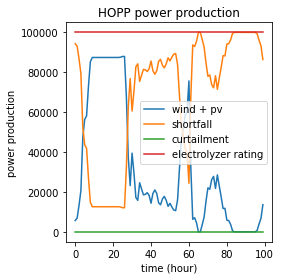

Turbine Power Output (to identify powercurve impact): 431941300.4291993


In [388]:
if plot_power_production:
    plt.figure(figsize=(4,4))
    plt.title("HOPP power production")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],label="wind + pv")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.xlabel("time (hour)")
    plt.ylabel("power production")
    # plt.ylim(0,250000)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Turbine Power Output (to identify powercurve impact):", hybrid_plant.wind.annual_energy_kw)

# Step 5: Run Simple Dispatch Model


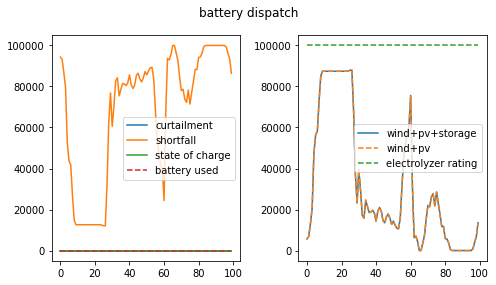

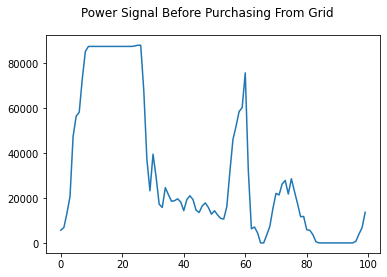

In [389]:
bat_model = SimpleDispatch()
bat_model.Nt = len(energy_shortfall_hopp)
bat_model.curtailment = combined_pv_wind_curtailment_hopp
bat_model.shortfall = energy_shortfall_hopp

bat_model.battery_storage = storage_size_mwh * 1000
bat_model.charge_rate = storage_size_mw * 1000
bat_model.discharge_rate = storage_size_mw * 1000

battery_used, excess_energy, battery_SOC = bat_model.run()
combined_pv_wind_storage_power_production_hopp = combined_pv_wind_power_production_hopp + battery_used

if plot_battery:
    plt.figure(figsize=(7,4))
    plt.subplot(121)
    plt.plot(combined_pv_wind_curtailment_hopp[200:300],label="curtailment")
    plt.plot(energy_shortfall_hopp[200:300],label="shortfall")
    plt.plot(battery_SOC[200:300],label="state of charge")
    # plt.ylim(0,350000)
    # plt.plot(excess_energy[200:300],label="excess")
    plt.plot(battery_used[200:300],"--",label="battery used")
    plt.legend()

    plt.subplot(122)
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="wind+pv+storage")
    plt.plot(combined_pv_wind_power_production_hopp[200:300],"--",label="wind+pv")
    plt.plot(load[200:300],"--",label="electrolyzer rating")
    # plt.ylim(0,225000)

    plt.legend()
    plt.suptitle("battery dispatch")
    plt.tight_layout()

    plt.show()

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],label="before buy from grid")
    plt.suptitle("Power Signal Before Purchasing From Grid")

if sell_price:
    profit_from_selling_to_grid = np.sum(excess_energy)*sell_price
else:
    profit_from_selling_to_grid = 0.0

# buy_price = False # if you want to force no buy from grid
if buy_price:
    cost_to_buy_from_grid = 0.0

    for i in range(len(combined_pv_wind_storage_power_production_hopp)):
        if combined_pv_wind_storage_power_production_hopp[i] < kw_continuous:
            cost_to_buy_from_grid += (kw_continuous-combined_pv_wind_storage_power_production_hopp[i])*buy_price
            combined_pv_wind_storage_power_production_hopp[i] = kw_continuous
else:
    cost_to_buy_from_grid = 0.0

energy_to_electrolyzer = [x if x < kw_continuous else kw_continuous for x in combined_pv_wind_storage_power_production_hopp]



### Plot Dispatch Results

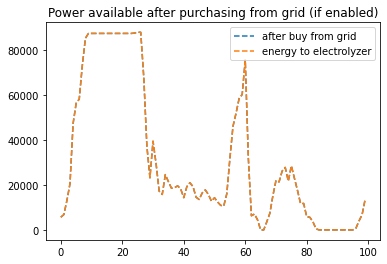

In [397]:

if plot_grid:
    plt.plot(combined_pv_wind_storage_power_production_hopp[200:300],"--",label="after buy from grid")
    plt.plot(energy_to_electrolyzer[200:300],"--",label="energy to electrolyzer")
    plt.legend()
    plt.title('Power available after purchasing from grid (if enabled)')
    plt.show()



# Step 6: Run the H2_PEM model

Total power input to electrolyzer: 433485055.1204543
Hydrogen Annual Output (kg): 7471263.6445824625
Water Consumption (kg) Total: 74712636.44582324


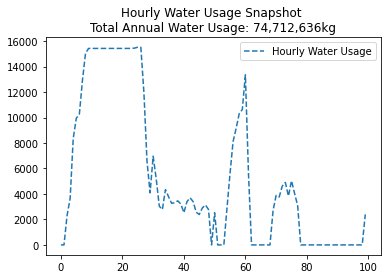

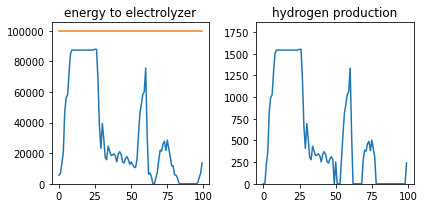

In [398]:
#TODO: Refactor H2A model call
# Add H2 production plot
# Should take as input (electrolyzer size, cost, electrical timeseries, total system electrical usage (kwh/kg),
# Should give as ouptut (h2 costs by net cap cost, levelized, total_unit_cost of hydrogen etc)   )

# electrical_generation_timeseries = combined_pv_wind_storage_power_production_hopp
electrical_generation_timeseries = np.zeros_like(energy_to_electrolyzer)
electrical_generation_timeseries[:] = energy_to_electrolyzer[:]

adjusted_installed_cost = hybrid_plant.grid._financial_model.Outputs.adjusted_installed_cost
#NB: adjusted_installed_cost does NOT include the electrolyzer cost
useful_life = scenario['Useful Life']
net_capital_costs = 0

# system_rating = electrolyzer_size
system_rating = wind_size_mw + solar_size_mw
H2_Results, H2A_Results = run_h2_PEM.run_h2_PEM(electrical_generation_timeseries,electrolyzer_size,
                kw_continuous,forced_electrolyzer_cost,lcoe,adjusted_installed_cost,useful_life,
                net_capital_costs)


H2_Results['hydrogen_annual_output'] = H2_Results['hydrogen_annual_output']

print("Total power input to electrolyzer: {}".format(np.sum(electrical_generation_timeseries)))
print("Hydrogen Annual Output (kg): {}".format(H2_Results['hydrogen_annual_output']))
print("Water Consumption (kg) Total: {}".format(H2_Results['water_annual_usage']))

plt.plot(H2_Results['water_hourly_usage'][200:300],"--",label="Hourly Water Usage")
plt.legend()
plt.title('Hourly Water Usage Snapshot \n' 'Total Annual Water Usage: {0:,.0f}kg'.format(H2_Results['water_annual_usage']))
plt.show()

if plot_h2:
    hydrogen_hourly_production = H2_Results['hydrogen_hourly_production']
    plt.figure(figsize=(6,3))
    plt.subplot(121)
    plt.plot(electrical_generation_timeseries[200:300])
    plt.ylim(0,max(electrical_generation_timeseries[200:300])*1.2)
    plt.plot(load[200:300],label="electrolyzer rating")
    plt.title("energy to electrolyzer")

    plt.subplot(122)
    plt.plot(hydrogen_hourly_production[200:300])
    plt.ylim(0,max(hydrogen_hourly_production[200:300])*1.2)
    plt.title("hydrogen production")
    plt.tight_layout()
    plt.show()

# Step 6b: Run desal model

Max power allowed by system:  52.75675675675676 kW
For 100MW Electrolyzer, implementing 18.01801801801802m^3/hr desal system
Estimated constant desal power usage 0.053MW
Desal System CAPEX ($): 164,140.73
Desal System OPEX ($): 24,156.54
Total Annual Feedwater Required (m^3): 310,808.03


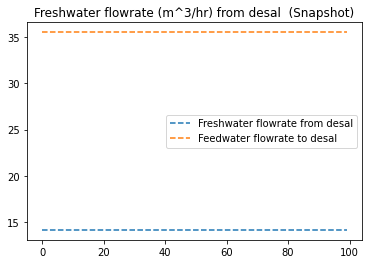

In [392]:
from examples.H2_Analysis.desal_model import RO_desal


water_usage_electrolyzer = H2_Results['water_hourly_usage']
m3_water_per_kg_h2 = 0.01
desal_system_size_m3_hr = electrolyzer_size * (1000/55.5) * m3_water_per_kg_h2
est_const_desal_power_mw_hr = desal_system_size_m3_hr * 2.928 /1000 # 4kWh/m^3 desal efficiency estimate
Power = [(est_const_desal_power_mw_hr) * 1000 for x in range(0, 8760)]
fresh_water_flowrate, feed_water_flowrate, desal_capex, desal_opex = RO_desal(Power, desal_system_size_m3_hr)
print("For {}MW Electrolyzer, implementing {}m^3/hr desal system".format(electrolyzer_size, desal_system_size_m3_hr))
print("Estimated constant desal power usage {0:.3f}MW".format(est_const_desal_power_mw_hr))
print("Desal System CAPEX ($): {0:,.02f}".format(desal_capex))
print("Desal System OPEX ($): {0:,.02f}".format(desal_opex))
# print("Freshwater Flowrate (m^3/hr): {}".format(fresh_water_flowrate))
print("Total Annual Feedwater Required (m^3): {0:,.02f}".format(np.sum(feed_water_flowrate)))

plt.plot(fresh_water_flowrate[200:300],"--",label="Freshwater flowrate from desal")
plt.plot(feed_water_flowrate[200:300],"--",label="Feedwater flowrate to desal")
plt.legend()
plt.title('Freshwater flowrate (m^3/hr) from desal  (Snapshot)'.format(fresh_water_flowrate))
plt.show()

## Static Pressure Vessel Model Example

In [403]:
from examples.H2_Analysis.pressure_vessel_model import static_pressure_vessel
storage_volume, compressor_work, pressure_vessel_capex, pressure_vessel_opex = static_pressure_vessel(H2_storage = True)

H2 Storage volume:  4007.9665 [m^3] Compressor Work:  380.9388 [kWh] Pressure Vessel Capex:  17500000 [USD] Pressure Vessel Opex:  2625000 [USD/yr]


# Step 6.5: Intermediate financial calculation

In [395]:
total_elec_production = np.sum(electrical_generation_timeseries)
total_hopp_installed_cost = hybrid_plant.grid._financial_model.SystemCosts.total_installed_cost
total_electrolyzer_cost = H2A_Results['scaled_total_installed_cost']
total_system_installed_cost = total_hopp_installed_cost + total_electrolyzer_cost
annual_operating_cost_hopp = (wind_size_mw * 1000 * 42) + (solar_size_mw * 1000 * 13)
annual_operating_cost_h2 = H2A_Results['Fixed O&M'] * H2_Results['hydrogen_annual_output']
total_annual_operating_costs = annual_operating_cost_hopp + annual_operating_cost_h2 + cost_to_buy_from_grid - profit_from_selling_to_grid
# h_lcoe_no_op_cost = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
#                    0, 0.07, useful_life)

h_lcoe = lcoe_calc((H2_Results['hydrogen_annual_output']), total_system_installed_cost,
                    total_annual_operating_costs, discount_rate, useful_life)

# Cashflow Financial Calculation
discount_rate = scenario['Discount Rate']
cf_wind_annuals = hybrid_plant.wind._financial_model.Outputs.cf_annual_costs
cf_solar_annuals = hybrid_plant.pv._financial_model.Outputs.cf_annual_costs
cf_h2_annuals = H2A_Results['expenses_annual_cashflow'] # This might be unreliable. 
cf_operational_annuals = [-total_annual_operating_costs for i in range(30)]

cf_df = pd.DataFrame([cf_wind_annuals, cf_solar_annuals, cf_h2_annuals[:len(cf_wind_annuals)]],['Wind', 'Solar', 'H2'])
# parent_path = os.path.abspath('')
# print(parent_path)
results_dir = parent_path + '/examples/H2_Analysis/results/'
cf_df.to_csv(os.path.join(results_dir, "Annual Cashflows_{}_{}_{}_discount_{}.csv".format(site_name, scenario_choice, atb_year, discount_rate)))

#NPVs of wind, solar, H2

npv_wind_costs = npf.npv(discount_rate, cf_wind_annuals)
npv_solar_costs = npf.npv(discount_rate, cf_solar_annuals)
npv_h2_costs = npf.npv(discount_rate, cf_h2_annuals)
npv_operating_costs = npf.npv(discount_rate, cf_operational_annuals)
npv_total_costs = npv_wind_costs+npv_solar_costs+npv_h2_costs
npv_total_costs_w_operating_costs = npv_wind_costs+npv_solar_costs+npv_h2_costs+npv_operating_costs

LCOH_cf_method = -npv_total_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
LCOH_cf_method_w_operating_costs = -npv_total_costs_w_operating_costs / (H2_Results['hydrogen_annual_output'] * useful_life)
financial_summary_df = pd.DataFrame([scenario['Useful Life'], wind_cost_kw, solar_cost_kw, forced_electrolyzer_cost,
                                        scenario['Debt Equity'], atb_year, ptc_avail, itc_avail,
                                        discount_rate, npv_wind_costs, npv_solar_costs, npv_h2_costs, LCOH_cf_method],
                                    ['Useful Life', 'Wind Cost KW', 'Solar Cost KW', 'Electrolyzer Cost KW', 'Debt Equity',
                                        'ATB Year', 'PTC available', 'ITC available', 'Discount Rate', 'NPV Wind Expenses', 'NPV Solar Expenses', 'NPV H2 Expenses', 'LCOH cf method'])
financial_summary_df.to_csv(os.path.join(results_dir, 'Financial Summary.csv'))

# Gut Check H2 calculation (non-levelized)
total_installed_and_operational_lifetime_cost = total_system_installed_cost + (30 * total_annual_operating_costs)
lifetime_h2_production = 30 * H2_Results['hydrogen_annual_output']
gut_check_h2_cost_kg = total_installed_and_operational_lifetime_cost / lifetime_h2_production

# Step 7: Print  Results

In [396]:
print_results = False
print_h2_results = True

if print_results:
    # ------------------------- #
    #TODO: Tidy up these print statements
    print("Future Scenario: {}".format(scenario['Scenario Name']))
    print("Wind Cost per KW: {}".format(scenario['Wind Cost KW']))
    print("PV Cost per KW: {}".format(scenario['Solar Cost KW']))
    print("Storage Cost per KW: {}".format(scenario['Storage Cost kW']))
    print("Storage Cost per KWh: {}".format(scenario['Storage Cost kWh']))
    print("Wind Size built: {}".format(wind_size_mw))
    print("PV Size built: {}".format(solar_size_mw))
    print("Storage Size built: {}".format(storage_size_mw))
    print("Storage Size built: {}".format(storage_size_mwh))
    print("Levelized cost of Electricity (HOPP): {}".format(lcoe))
    print("Total Yearly Electrical Output: {}".format(total_elec_production))
    print("Total Yearly Hydrogen Production: {}".format(H2_Results['hydrogen_annual_output']))
    print("Levelized Cost H2/kg (new method - no operational costs)".format(h_lcoe_no_op_cost))
    print("Capacity Factor of Electrolyzer: {}".format(H2_Results['cap_factor']))

if print_h2_results:
    print('Total Lifetime H2(kg) produced: {}'.format(lifetime_h2_production))
    print("Gut-check H2 cost/kg: {}".format(gut_check_h2_cost_kg))
    print("h_lcoe: ", h_lcoe)
    print("LCOH CF Method (doesn't include grid electricity cost if used)", LCOH_cf_method)
    print("LCOH CF Method (includes operating costs + electricity)", LCOH_cf_method_w_operating_costs)
    # print("Levelized cost of H2 (electricity feedstock) (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_levelized_hopp']))
    # print("Levelized cost of H2 (excl. electricity) (H2A): {}".format(H2A_Results['Total Hydrogen Cost ($/kgH2)']))
    # print("Total unit cost of H2 ($/kg) : {}".format(H2_Results['total_unit_cost_of_hydrogen']))
    # print("kg H2 cost from net cap cost/lifetime h2 production (HOPP): {}".format(
    #     H2_Results['feedstock_cost_h2_via_net_cap_cost_lifetime_h2_hopp']))

KeyError: 'Scenario Name'

# Step 8: Plot Results

# Step 9: Save Results

### Create output dictionary

In [ ]:
def establish_save_output_dict():
    """
    Establishes and returns a 'save_outputs_dict' dict
    for saving the relevant analysis variables for each site.
    """

    save_outputs_dict = dict()
    save_outputs_dict['Site Name'] = list()
    save_outputs_dict['Scenario Choice'] = list()
    save_outputs_dict['Site Lat'] = list()
    save_outputs_dict['Site Lon'] = list()
    save_outputs_dict['ATB Year'] = list()
    save_outputs_dict['Resource Year'] = list()
    save_outputs_dict['Critical Load Factor'] = list()
    save_outputs_dict['kW continuous load'] = list()
    save_outputs_dict['Useful Life'] = list()
    save_outputs_dict['PTC'] = list()
    save_outputs_dict['ITC'] = list()
    save_outputs_dict['Discount Rate'] = list()
    save_outputs_dict['Debt Equity'] = list()
    save_outputs_dict['Hub Height (m)'] = list()
    save_outputs_dict['Storage Enabled'] = list()
    save_outputs_dict['Wind Cost kW'] = list()
    save_outputs_dict['Solar Cost kW'] = list()
    save_outputs_dict['Storage Cost kW'] = list()
    save_outputs_dict['Storage Cost kWh'] = list()
    save_outputs_dict['Storage Hours'] = list()
    save_outputs_dict['Wind MW built'] = list()
    save_outputs_dict['Solar MW built'] = list()
    save_outputs_dict['Storage MW built'] = list()
    save_outputs_dict['Storage MWh built'] = list()
    save_outputs_dict['Electrolyzer Size'] = list()
    save_outputs_dict['Electrolyzer Total System Size'] = list()
    save_outputs_dict['Battery Can Grid Charge'] = list()
    save_outputs_dict['Grid Connected HOPP'] = list()
    save_outputs_dict['Built Interconnection Size'] = list()
    save_outputs_dict['Total Installed Cost $(HOPP)'] = list()
    save_outputs_dict['Total Yearly Electrical Output'] = list()
    save_outputs_dict['LCOE'] = list()
    save_outputs_dict['Total Annual H2 production (kg)'] = list()
    save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'] = list()
    save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'] = list()
    save_outputs_dict['H2A scaled total install cost'] = list()
    save_outputs_dict['H2A scaled total install cost per kw'] = list()
    save_outputs_dict['HOPP Total Generation'] = list()
    save_outputs_dict['Wind Capacity Factor'] = list()
    save_outputs_dict['HOPP Energy Shortfall'] = list()
    save_outputs_dict['HOPP Curtailment'] = list()
    save_outputs_dict['Battery Generation'] = list()
    save_outputs_dict['Electricity to Grid'] = list()
    
    return save_outputs_dict

In [ ]:
save_outputs_dict = establish_save_output_dict()

In [ ]:
# Step 9: Plot HOPP Production, Curtailment, and Hydrogen Production Profiles
# ------------------------- #
#TODO: Place in function

save_outputs_dict['Site Name'].append(site_name)
save_outputs_dict['Scenario Choice'].append(scenario_choice)
save_outputs_dict['Site Lat'].append(lat)
save_outputs_dict['Site Lon'].append(lon)
save_outputs_dict['ATB Year'].append(atb_year)
save_outputs_dict['Resource Year'].append(resource_year)
save_outputs_dict['Critical Load Factor'].append(critical_load_factor)
save_outputs_dict['kW continuous load'].append(kw_continuous)
save_outputs_dict['Useful Life'].append(useful_life)
save_outputs_dict['PTC'].append(ptc_avail)
save_outputs_dict['ITC'].append(itc_avail)
save_outputs_dict['Discount Rate'].append(discount_rate)
save_outputs_dict['Debt Equity'].append(debt_equity_split)
save_outputs_dict['Hub Height (m)'].append(tower_height)
save_outputs_dict['Storage Enabled'].append(storage_used)
save_outputs_dict['Wind Cost kW'].append(wind_cost_kw)
save_outputs_dict['Solar Cost kW'].append(solar_cost_kw)
save_outputs_dict['Storage Cost kW'].append(storage_cost_kw)
save_outputs_dict['Storage Cost kWh'].append(storage_cost_kwh)
save_outputs_dict['Storage Hours'].append(storage_hours)
save_outputs_dict['Wind MW built'].append(wind_size_mw)
save_outputs_dict['Solar MW built'].append(solar_size_mw)
save_outputs_dict['Storage MW built'].append(storage_size_mw)
save_outputs_dict['Storage MWh built'].append(storage_size_mwh)
save_outputs_dict['Battery Can Grid Charge'].append(battery_can_grid_charge)
save_outputs_dict['Built Interconnection Size'].append(hybrid_plant.interconnect_kw)
save_outputs_dict['Total Installed Cost $(HOPP)'].append(total_hopp_installed_cost)
save_outputs_dict['Total Yearly Electrical Output'].append(total_elec_production)
save_outputs_dict['LCOE'].append(lcoe)
save_outputs_dict['Total Annual H2 production (kg)'].append(H2_Results['hydrogen_annual_output'])
save_outputs_dict['Gut-Check Cost/kg H2 (non-levelized, includes elec if used)'].append(gut_check_h2_cost_kg)
save_outputs_dict['Levelized Cost/kg H2 (lcoe using installed and operation costs)'].append(h_lcoe)
save_outputs_dict['Levelized Cost/kg H2 (CF Method - using annual cashflows per technology)'].append(LCOH_cf_method)
save_outputs_dict['Grid Connected HOPP'].append(grid_connected_hopp)
save_outputs_dict['HOPP Total Generation'].append(np.sum(hybrid_plant.grid.generation_profile[0:8759]))
save_outputs_dict['Wind Capacity Factor'].append(hybrid_plant.wind._system_model.Outputs.capacity_factor)
save_outputs_dict['HOPP Energy Shortfall'].append(np.sum(energy_shortfall_hopp))
save_outputs_dict['HOPP Curtailment'].append(np.sum(combined_pv_wind_curtailment_hopp))
save_outputs_dict['Battery Generation'].append(np.sum(battery_used))
save_outputs_dict['Electricity to Grid'].append(np.sum(excess_energy))
save_outputs_dict['Electrolyzer Size'].append(H2A_Results['electrolyzer_size'])
save_outputs_dict['Electrolyzer Total System Size'].append(H2A_Results['total_plant_size'])
save_outputs_dict['H2A scaled total install cost'].append(H2A_Results['scaled_total_installed_cost'])
save_outputs_dict['H2A scaled total install cost per kw'].append(H2A_Results['scaled_total_installed_cost_kw'])


# save_all_runs = save_all_runs.append(save_outputs_dict, sort=False)
# Create dataframe from outputs and save
save_outputs = True
if save_outputs:
    save_outputs_dict_df = pd.DataFrame(save_outputs_dict)
    save_outputs_dict_df.to_csv(os.path.join(results_dir, "H2_Analysis_{}.csv".format('Main')))
    

# ~~Step 2a: Load scenarios from .csv and enumerate~~

In [383]:
# # Setting all scenario inputs manuall for now

# # parent_path = os.path.abspath('')
# # print(parent_path)
# # scenarios_df = pd.read_csv(os.path.join(parent_path,'examples/H2_Analysis/osw_h2_scenario.csv'))

# for i, scenario in scenarios_df.iterrows():
#     kw_continuous = electrolyzer_size * 1000
#     load = [kw_continuous for x in
#             range(0, 8760)]  # * (sin(x) + pi) Set desired/required load profile for plant

#     scenario_choice = scenario['Scenario Name']
#     site_name = scenario['Site Name']
#     sample_site['lat'] = scenario['Lat']
#     sample_site['lon'] = scenario['Long']
#     lat = scenario['Lat']
#     lon = scenario['Long']
#     atb_year = scenario['ATB Year']
#     ptc_avail = scenario['PTC Available']
#     itc_avail = scenario['ITC Available']
#     forced_sizes = scenario['Force Plant Size']
#     force_electrolyzer_cost = scenario['Force Electrolyzer Cost']
#     if forced_sizes:
#         forced_wind_size = scenario['Wind Size MW']
#         forced_solar_size = scenario['Solar Size MW']
#         forced_storage_size_mw = scenario['Storage Size MW']
#         forced_storage_size_mwh = scenario['Storage Size MWh']
#     else:
#         print("Using ReOPT for sizing. REopt will be turned on and may not find a solution")
#         run_reopt_flag = True

#     if force_electrolyzer_cost:
#         forced_electrolyzer_cost = scenario['Electrolyzer Cost KW']

#     wind_cost_kw = scenario['Wind Cost KW']
#     solar_cost_kw = scenario['Solar Cost KW']
#     storage_cost_kw = scenario['Storage Cost KW']
#     storage_cost_kwh = scenario['Storage Cost KWh']
#     debt_equity_split = scenario['Debt Equity']

#     buy_price = scenario['Buy From Grid ($/kWh)']
#     sell_price = scenario['Sell To Grid ($/kWh)']

#     #Todo: Add useful life to .csv scenario input instead
#     scenario['Useful Life'] = useful_life

#     site = SiteInfo(sample_site, hub_height=tower_height)
# # scenarios_df